In [5]:
%pip install pandas matplotlib ipykernel pillow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import urllib3

# Настройки (берем из ENV или хардкодим для ноутбука)
MINIO_ENDPOINT = os.getenv("MINIO_S3_ENDPOINT_URL", "https://s3.k8s.dgoi.ru") # Твой адрес
ACCESS_KEY = os.getenv("MINIO_ACCESS_KEY", "zOw8x0hri01phOFO5POr") # Твой ключ
SECRET_KEY = os.getenv("MINIO_SECRET_KEY", "zi5HjnYiWZhn07IjrwpvL3wZoJ72JrR4YuyR63Nr") # Твой секрет
BUCKET_NAME = "leukemia-data"

# Отключаем ворнинги SSL
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def get_s3_client():
    return boto3.client('s3',
                        endpoint_url=MINIO_ENDPOINT,
                        aws_access_key_id=ACCESS_KEY,
                        aws_secret_access_key=SECRET_KEY) #,
                        #verify=False)

s3 = get_s3_client()
print("Connected to MinIO!")

Connected to MinIO!


In [8]:
# Получаем список всех объектов в бакете
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET_NAME, Prefix="C-NMC_Leukemia/")

file_paths = []
for page in pages:
    if 'Contents' in page:
        for obj in page['Contents']:
            file_paths.append(obj['Key'])

print(f"Total files found: {len(file_paths)}")

# Создаем DataFrame
df = pd.DataFrame(file_paths, columns=['path'])

# Фильтруем только картинки (bmp, jpg, png)
df = df[df['path'].str.lower().str.endswith(('.bmp', '.jpg', '.png'))]

# Извлекаем метки классов из пути
# Структура C-NMC обычно такая: .../fold_0/all/image.bmp или .../fold_0/hem/image.bmp
# 'all' = Acute Lymphoblastic Leukemia (Рак)
# 'hem' = Normal (Здоровые)

def extract_label(path):
    if '/all/' in path.lower():
        return 'Leukemia (ALL)'
    elif '/hem/' in path.lower():
        return 'Normal (HEM)'
    else:
        return 'Unknown'

df['label'] = df['path'].apply(extract_label)
df = df[df['label'] != 'Unknown'] # Убираем мусор, если есть

print(df.head())

Total files found: 15115
                                                   path           label
2586  C-NMC_Leukemia/training_data/fold_0/all/UID_11...  Leukemia (ALL)
2587  C-NMC_Leukemia/training_data/fold_0/all/UID_11...  Leukemia (ALL)
2588  C-NMC_Leukemia/training_data/fold_0/all/UID_11...  Leukemia (ALL)
2589  C-NMC_Leukemia/training_data/fold_0/all/UID_11...  Leukemia (ALL)
2590  C-NMC_Leukemia/training_data/fold_0/all/UID_11...  Leukemia (ALL)


label
Leukemia (ALL)    7272
Normal (HEM)      3389
Name: count, dtype: int64


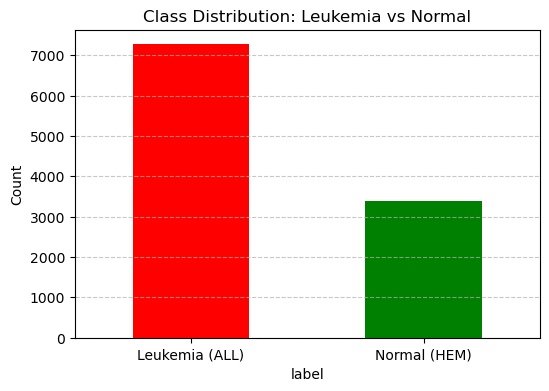

Imbalance Ratio: 2.15


/tmp/ipykernel_169/1281087532.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ratio = class_counts[0] / class_counts[1]


In [9]:
# Строим график распределения
class_counts = df['label'].value_counts()
print(class_counts)

plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Class Distribution: Leukemia vs Normal')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Вывод соотношения
ratio = class_counts[0] / class_counts[1]
print(f"Imbalance Ratio: {ratio:.2f}")

Examples of LEUKEMIA Cells:


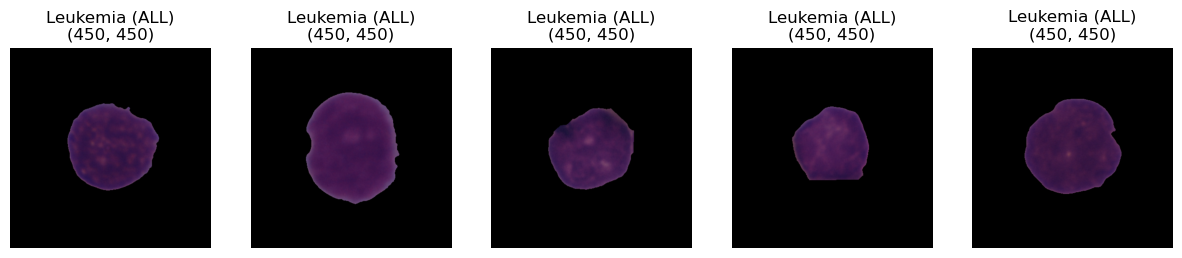

Examples of NORMAL Cells:


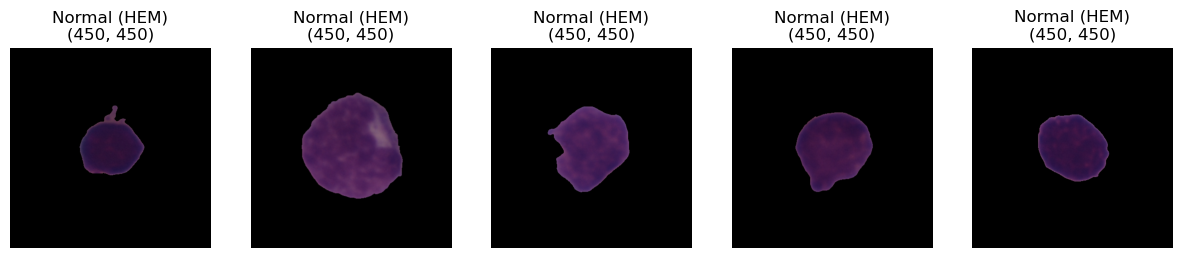

In [10]:
def load_image_from_minio(path):
    response = s3.get_object(Bucket=BUCKET_NAME, Key=path)
    img_data = response['Body'].read()
    return Image.open(BytesIO(img_data))

def plot_samples(label, num_samples=5):
    samples = df[df['label'] == label].sample(num_samples)['path'].values
    
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(samples):
        img = load_image_from_minio(path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{label}\n{img.size}")
    plt.show()

print("Examples of LEUKEMIA Cells:")
plot_samples('Leukemia (ALL)')

print("Examples of NORMAL Cells:")
plot_samples('Normal (HEM)')